## 0. Competition's Goal

The goal of this competition is to develop an automated way of identifying the relevant features within each patient note, with a special focus on the patient history portions of the notes where the information from the interview with the standardized patient is documented.

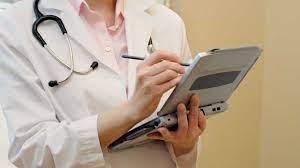

**Components :**
1. Import Libraries and Data
2. Feature Engineering & Text Pre-Processing
3. Modeling with BERT and NN
4. Inference and submission

## 1. Import Libraries & Data

In [ ]:
!mkdir -p /tmp/pip/cache/
!cp ../input/transf/sentence-transformers-0.3.2.xyz /tmp/pip/cache/sentence-transformers-0.3.2.tar.gz

In [ ]:
!pip install --no-index --find-links /tmp/pip/cache/ sentence_transformers

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
import re
from nltk import sent_tokenize
#nltk.download('punkt')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import keras
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from keras.models import Model

In [ ]:
DIR = '/kaggle/input/nbme-score-clinical-patient-notes/'

In [ ]:
features = pd.read_csv(DIR+'features.csv')
patient_notes = pd.read_csv(DIR+'patient_notes.csv')
submission = pd.read_csv(DIR+'sample_submission.csv')
test = pd.read_csv(DIR+'test.csv')
train = pd.read_csv(DIR+'train.csv')

In [ ]:
train.head()

In [ ]:
features.head()

In [ ]:
patient_notes.head()

We merge our three datasets to get a more significant one :

In [ ]:
df = pd.merge(train, patient_notes, on=['pn_num', "case_num" ] , how='inner')
df = pd.merge(df, features, on=['case_num', 'feature_num'], how = 'inner')

In [ ]:
df.head()

In [ ]:
df.shape

Let's see the number of annotations token for each note :

In [ ]:
df['nb of annotations'] = df.location.apply(lambda x:len(eval(x)))

Almost notes have zero, one or two annotations :

In [ ]:
df['nb of annotations'].value_counts() / df.shape[0] * 100

In [ ]:
_ , ax = plt.subplots(figsize=[22,8])
sns.countplot(x="nb of annotations", data=df, ax=ax)

Let's see the median of the number of annotations, that will help us to know how much annotations to take when modeling :

In [ ]:
df['nb of annotations'].median()

We create a new dataset with features to use later :

In [ ]:
new = df[['id','annotation','location', 'pn_history', 'feature_text']]

## 2. Feature Engineering & Text Pre-Processing

We first adjust location column :

In [ ]:
for idx in range(len(new)): 
    new["location"][idx] = new["location"][idx].replace(";" , "','")  
     # For replacing semicolon ";"  with comma  ","

new["location"] = new["location"].apply(eval)  # Converting to list

We will label rows with annotation and his feature with 1, and the other sentences  before and after it with 0 :

In [ ]:
feats = []
sents = []
labels = []
ids = []

for i in range(len(new)) :
    id_ = new.loc[i,'id']
    feat = new.loc[i,'feature_text']
    annot = eval(new.loc[i,'annotation'])
    loc = new.loc[i,'location']
    loc = [(int(l.split(' ')[0]), int(l.split(' ')[1])) for l in loc]
    notes_ = new.loc[i,'pn_history'].replace('\n', '.')
    
    # case with label = 1
    sents.extend(annot)
    feats.extend([feat]*len(annot))
    labels.extend([1]*len(annot))
    ids.extend([id_]*len(annot))
    
    # we loop over text before and after annotations
    for idx,(s, e) in enumerate(loc) :
        try :
            before_an = sent_tokenize(notes_[loc[idx-1][1]:s]) # do it for each annot
            after_an = sent_tokenize(notes_[e:loc[idx+1][0]])
        except :
            before_an = sent_tokenize(notes_[:s]) # do it for each annot
            after_an = sent_tokenize(notes_[e:])
            
        # case with label = 0    
        sents.extend(before_an)
        sents.extend(after_an)
        n = len(before_an+after_an)
        feats.extend([feat]*n)
        labels.extend([0]*n)
        ids.extend([id_]*n)
        

In [ ]:
# we create our dataset to use in modeling
fornn = pd.DataFrame(list(zip(ids, sents, feats, labels)),
               columns =['id','sent','feature', 'label'])
fornn.head()

Unfortunately our data is not balanced, but we will keep going on with it :

In [ ]:
fornn.label.value_counts() / fornn.shape[0] * 100

We create a helper fuction to clean our data :

In [ ]:
stopwords = pd.read_csv('../input/nltk-english-stopwords/nltk_eng_stopwords.csv').list_of_stopwords.values

In [ ]:
def process(paragraph) :
    ps = PorterStemmer()
    corpus = []
    
    # keep just letters and turn it into lowercase
    paragraph = paragraph.replace('-', ' ')
    cleaned = re.sub('[^a-zA-Z]', ' ', paragraph)
    cleaned = cleaned.lower().split()

    #remove stopwords + stemming 
    cleaned = [ps.stem(word) for word in cleaned if not word in stopwords]
    cleaned = ' '.join(cleaned)
    #corpus.append(cleaned)

    return cleaned

## 3. Modeling : BERT & NN

We try now to get sentences embeddings using DistilBERT.

**WHAT is DistilBERT ?**

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT
 base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving 
over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

PS : distillation: a technique you can use to compress a large model, called the teacher, 
into a smaller model, called the student.

I used the version offered by Hagging Face Transformer.

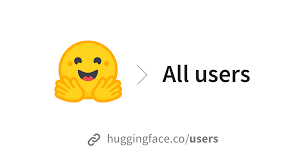

First we need to process our data thus we can use it with our encoder :

In [ ]:
fornn['sent'] = fornn['sent'].apply(process)
fornn['feature'] = fornn['feature'].apply(process)

In [ ]:
fornn.head()

I used the distilBert model from HuggingFace transformers but it was not working on kaggle (even it was when running whitout errors locally) and because internet is not allowed I got the embeddings using the following commented code, pickle it then use it here directly.

PS : I traied to use AutoTokenizer and AutoModel from transformers library but it takes a lot of time.

```
modelB = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

corpus = fornn.loc[:, 'sent']
emb_sent =  modelB.encode(corpus)

corpus = fornn.loc[:, 'feature']
emb_feat =  modelB.encode(corpus)

encoding_data_file_quest1='encoding_sen'
encoding_data_file_quest2='encoding_feat'

with open(encoding_data_file_quest1, "wb") as fp:
		pickle.dump(emb_sent, fp)
  
with open(encoding_data_file_quest2, "wb") as fp:
		pickle.dump(emb_feat, fp)

```

In [ ]:
# We get our sentences and features embeddings :

encoding_data_file_quest1='../input/embeddings/encoding_sen'
encoding_data_file_quest2='../input/embeddings/encoding_feat'

In [ ]:
with open(encoding_data_file_quest1, "rb") as fp:
		emb_sent=pickle.load(fp)
	
with open(encoding_data_file_quest2, "rb") as fp:   
		emb_feat=pickle.load(fp)

In [ ]:
train_vec1 = np.asarray(emb_sent, np.float32)
train_vec2 = np.asarray(emb_feat, np.float32)
train_label = np.asarray(fornn.loc[:, 'label'],np.float32)

We now create our Neural Network architecture, to detect if a feature and note are related or not :

In [ ]:
input1 = Input(shape=(768,))
input2 = Input(shape=(768,))

# we concatenate the two inputs = embeddings for each feature with associated sentence
x = keras.layers.concatenate([input1,input2], axis=-1)

# we add a three dense layers with three dropout layers for oferfitting reasons, the last Dense layer is to return the similarity score between -1 and 1  
x = Dense(1024,activation='relu') (x)
x = Dropout(0.5) (x)
x = Dense(256,activation='relu') (x)
x = Dropout(0.5) (x)
x = Dense(64,activation='relu') (x)

output = Dense(1,activation='sigmoid') (x)

model = Model(inputs=[input1,input2],outputs=output)
model.summary()

# we compile our model
model.compile(optimizer='rmsprop',
  loss='binary_crossentropy',
  metrics=['acc'])

In [ ]:
history=model.fit([train_vec1, train_vec2], train_label, 
    epochs=30,batch_size=200,
    validation_split=0.2) # we can add an early stopping param

## 4. Inference

Here we prepare our test data :

In [ ]:
ntest = pd.merge(test, df.drop(['id', 'case_num', 'location', 'annotation','nb of annotations'], axis=1)
             , on = ['pn_num', 'feature_num'], how = 'inner')

ntest = ntest.drop(['case_num','pn_num','feature_num'],axis=1)
ntest.head()

And then we get predictions, sort it and find location in patient notes :

**PS** : The following code is used localy to get predictions but again because of the problem of access to internet ... I just uploaded the embeddings and results from localy.

```

res = []
loc = []

for feat, notes in zip(ntest.feature_text.values, ntest.pn_history.values) :
    sentences = sent_tokenize(notes.replace('\n','.'))
    each = []
    
    # we process the given sentences then get the embeddings
    for s in sentences :
        each.extend(re.split(', |\r', s.replace('"',' '))) #     s.split(', | \r')
    sentencesp = [process(elt) for elt in each ]
    sentences_ = modelB.encode(sentencesp)
    sentences_ = np.asarray(sentences_, np.float32)
    
    # we do the same with the feature
    n = len(sentences_)
    featp = process(feat)
    feat_ = modelB.encode(featp)
    feat_ = [feat_]*n
    feat_ = np.asarray(feat_, np.float32)
    
    # we get the two more relevant predictions
    preds = model.predict([sentences_, feat_], batch_size=200)
    sen = np.argsort(preds[:,0])[-2:]
    rel = [each[idx] for idx in sen]
    
    # as the model don't pick sometimes sentences where the feature is mentioned we add it manualy to our results
    add = [feat.lower().replace('-',' ') for sen in sentencesp if ((featp in sen)|(sen in featp))]
    rel.extend(add)
    res.append(rel)
    
    l = [f'{notes.find(elt)} {notes.find(elt)+len(elt)}' for elt in rel if notes.find(elt)!=-1]
    loc.append(l)
 ```

In [ ]:
encoding_data_file_quest1='../input/additional/res'
encoding_data_file_quest2='../input/additional/loc'

#with open(encoding_data_file_quest1, "wb") as fp:
#		pickle.dump(res, fp)
  
#with open(encoding_data_file_quest2, "wb") as fp:
#		pickle.dump(loc, fp)
  
with open(encoding_data_file_quest1, "rb") as fp:
		res=pickle.load(fp)
	
with open(encoding_data_file_quest2, "rb") as fp:   
		loc=pickle.load(fp)

In [ ]:
res

In [ ]:
loc

In [ ]:
loc = [';'.join(elt) for elt in loc]

In [ ]:
submission['location'] = loc
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)

## Please if you like the notebook, don't forget to upvote it !